# 인공지능을 활용한 유방암 예측

유방암은 전 세계의 여성들 사이에서 가장 흔한 암으로, 전체 암 사례의 25%를 차지하고 있습니다. 아무리 치료 기술이 발전한다고 하더라도 암은 무서운 질병이 아닐 수 없습니다. 따라서 암의 초기 단계에 적절한 조치를 취하는 것이 무엇보다 중요합니다. 검사가 더 간단해질수록 더 많은 사람들이 초기에 암을 발견할 수 있습니다. 이번 수업에서는 인공지능을 통해 양성(암)과 음성(암이 아님) 종양을 구별하는 법에 대해 알아보겠습니다.

## 문제의 정의

해결하고자 하는 문제를 수학적으로 명확히 정의해야 인공지능을 활용할 수 있습니다. 우리가 인공지능에게 기대하는 출력은 다음과 같습니다.

**출력 <span style="color: #4338ca;">주어진 데이터를 바탕으로 종양이 양성일 가능성이 높으면 1, 음성일 가능성이 높으면 0을 출력한다.</span>**

목표를 달성하기 위해서는 종양의 양성 여부와 강한 상관관계가 있는 데이터를 구해야 합니다. 자세한 내용은 Feature Selection & Feature Engineering 편에서 다루도록 하고, 오늘은 인터넷에서 구할 수 있는 데이터를 사용해 보겠습니다.

<b>입력 <span style="color: #4338ca;">위스콘신 유방암 데이터셋</span></b> *Street, William Nick et al. “Nuclear feature extraction for breast tumor diagnosis.” Electronic imaging (1993).* [(링크)](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic)

이 데이터셋은 실제 유방암 환자와 유방암을 앓고 있지 않은 대조군에게서 얻은 정보를 정리해 놓은 것입니다. 데이터셋은 현재 폴더의 `breast-cancer.csv` 파일에 저장되어 있으며, 각 항목에 대한 설명은 `breast-cancer.metadata.json`에 저장되어 있습니다. **아래의 버튼을 눌러 데이터셋에 대한 여러 가지 정보들을 확인하세요.**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, HTML
import ipywidgets as widgets
import numpy as np


df = pd.read_csv("./assets/breast-cancer.csv")

metadata = pd.read_json("./assets/breast-cancer.metadata.json")

class DummyOutput:
    def __repr__(self):
        return ""

In [2]:
info_button = widgets.Button(description="데이터셋 정보 보기")
head_button = widgets.Button(description="실제 데이터 보기")
meta_button = widgets.Button(description="데이터셋 설명 보기")
clear_button = widgets.Button(description="화면 지우기")
output1 = widgets.Output()

display(widgets.HBox([info_button, head_button, meta_button, clear_button]), output1)

def on_info_button_clicked(b):
    with output1:
        clear_output(wait=True)
        display(df.info())

def on_head_button_clicked(b):
    with output1:
        clear_output(wait=True)
        display(df.head(10))

def on_meta_button_clicked(b):
    class DummyOutput:
        def __repr__(self):
            return (f"{"Column":<24} Description\n"
                + f"{"------":<24} ----------\n"
                + "\n".join(f"{column['name']:<24} {column['description']}" for column in metadata["columns"]))
    with output1:
        clear_output(wait=True)
        display(DummyOutput())

def on_clear_button_clicked(b):
    with output1:
        clear_output()

info_button.on_click(on_info_button_clicked)
head_button.on_click(on_head_button_clicked)
meta_button.on_click(on_meta_button_clicked)
clear_button.on_click(on_clear_button_clicked)

    
DummyOutput()

Output()

## 인공지능 설계

위에서 정의한 문제를 해결할 알고리즘을 결정해 보겠습니다. 위의 문제는 **분류 문제**(Classification)의 일종으로, 주어진 사례를 분류하는(이 경우에는 종양의 양성 여부) 인공지능이 필요합니다. 하지만 항상 데이터 속에서 딱 맞는 사례를 발견할 수는 없습니다. 위의 데이터는 569개의 데이터만을 담고 있지만, 실제 세상에서 마주칠 수 있는 사례는 무한합니다. 이미 알고 있는 정보를 가지고 처음 보는 사례를 예측할 수 있어야 합니다. 어떻게 해야 할까요? 힌트는 근묵자흑(近墨者黑), **가까운 것들은 닮는다**입니다. 아래의 셀을 클릭해 정답을 확인하세요.

In [3]:
info_button = widgets.Button(description="정답 보기")
output2 = widgets.Output()

display(info_button, output2)

def on_info_button_clicked(b):
    content = """근묵자흑이라는 힌트가 주어졌습니다. 이 사자성어가 내포하고 있는 여러 가지 의미 중 한 가지는 "근처의 사람을 보면 그 사람이 누구인지 알 수 있다"는 것입니다. 우리가 세상의 모든 사람을 알고 있는 것은 아닙니다. 하지만 우리는 새로운 사람을 만나고, 때때로는 그 사람과 함께하기도 합니다. 우리는 어떻게 처음 본 사람을 믿을 수 있을까요? 바로 내가 믿을 수 있는 다른 사람들에게 소개받았기 때문입니다. 좋은 사람들과 가까운 사람이라면, 그 자신도 좋은 사람일 것입니다.
    데이터도 이와 비슷합니다. <b>지금까지 만나보지 못한 사례를 분류하기 위해서는 이와 가까운 사례들을 찾으면 됩니다.</b> 이것이 <b>k-Nearest Neighbors 알고리즘</b>의 핵심입니다. <b>새로운 사례가 주어졌을 때, 이미 알고 있는 사례들 중 가장 가까운 것들을 찾아서, 그 사례들이 어떤 분류에 속하는지를 통해 새로운 사례의 분류를 결정하는 것입니다.</b> 아래의 동영상을 통해 k-Nearest Neighbors 알고리즘에 대해서 알아보겠습니다."""
    with output2:
        clear_output(wait=True)
        display(HTML(f'<div style="background-color: #ede9fe; border-radius: 0.5rem; padding: 1rem; line-height: 1.5rem;">{content}</div>'))

info_button.on_click(on_info_button_clicked)

DummyOutput()

Button(description='정답 보기', style=ButtonStyle())

Output()

## 알고리즘 설명

<div style="display: flex;">
    <div style="flex-basis: 50%; flex-grow: 1; padding-right: 1rem;">
        <img src="./assets/KNNScene0000.png">
    </div>
    <div style="flex-basis: 50%; flex-grow: 1; padding: 1rem;">이 사진은 임의의 데이터를 2차원 그래프로 표현한 것입니다. k-Nearest Neighbors 알고리즘을 통해 중심에 있는 흰색 점의 색깔을 분류해 보겠습니다.</div>
</div>

<div style="display: flex;">
    <div style="flex-basis: 50%; flex-grow: 1; padding-right: 1rem;">
        <video controls autoplay width="100%">
            <source src="./assets/KNNScene_0000_sort_points.mp4" type="video/mp4">
            Your browser does not support the video tag.
        </video>
    </div>
    <div style="flex-basis: 50%; flex-grow: 1; padding: 1rem;">
        한 가지 궁금한 점은 어떻게 데이터 사이의 거리를 측정하는지입니다. 거리를 결정하는 여러 가지 방법이 있지만, 가장 떠올리기 쉬운 방법은 <b>그래프에서 표시된 점들 사이의 거리를 측정</b>하는 것입니다. 이를 고차원으로 확장하면 두 개 이상의 지표를 가진 데이터에 대해서도 거리를 결정할 수 있습니다. 실무에서는 <a href="https://en.wikipedia.org/wiki/Minkowski_distance">민코프스키 거리</a> 등이 자주 사용되며, 다른 방법으로도 <a href="https://en.wikipedia.org/wiki/Metric_space">거리</a>를 정의할 수 있습니다.
        <br />
        이렇게 측정된 <b>거리에 따라 알고 있는 사례들을 나열하고, 그 중 가장 가까운 몇 개를 선택</b>합니다. 이것이 k-Nearest Neighbors라는 이름이 붙은 이유입니다. 이 예시에서는 k=7을 사용합니다.
    </div>
</div>

<div style="display: flex;">
    <div style="flex-basis: 50%; flex-grow: 1; padding-right: 1rem;">
        <video controls autoplay width="100%">
            <source src="./assets/KNNScene_0001_filter_closest.mp4" type="video/mp4">
            Your browser does not support the video tag.
        </video>
    </div>
    <div style="flex-basis: 50%; flex-grow: 1; padding: 1rem;">
        가장 가까운 이웃 7개를 골랐습니다. 영상에서 알 수 있듯이, 이웃 중 빨간색은 0개, 노란색은 4개, 파란색은 3개가 존재합니다. <b>노란색이 가장 많기 때문에 k-Nearest Neighbors 알고리즘은 우리가 분류하고 싶은 점의 색깔이 노란색이라고 결론</b>짓습니다.
    </div>
</div>

## 실제 데이터에 적용

지금까지 배운 내용을 실제 문제에 적용시켜 보겠습니다. 아래의 코드를 참조하세요.

```python
from sklearn.preprocessing import StandardScaler

# 위에서 설명한 거리 함수입니다. 좌표값 차의 제곱을 모두 더해 제곱근을 구합니다.
dist = lambda a, b: sum((ae - be) ** 2 for ae, be in zip(a, b)) ** 0.5
argsort = lambda seq: sorted(range(len(seq)), key=seq.__getitem__)

# 근처의 사례 중 양성이 많은지, 음성이 많은지 확인합니다.
def predict(X_train, x, y_train, k):
    distances = [dist(x, xt) for xt in X_train]
    nearest = argsort(distances)
    return 1 if sum(y_train[i] for i in nearest[:k]) / k > 0.5 else 0

diag = df["diagnosis"].map({"M": 1, "B": 0})
df_noresult = df.drop("diagnosis", axis=1)

# 중요: 값들의 단위 또는 배율에 차이가 있기 때문에 데이터를 정규화해 주어야 합니다. 이는 Data Preprocessing 편에서 다룹니다.
scaler = StandardScaler()
scaler.fit(df_noresult)
df_scaled = scaler.transform(df_noresult)

result = [[0, 0], [0, 0]]

# 각 데이터를 검사합니다.
def check(i, df, diag):
    df_without_i = np.vstack([df[:i], df[i + 1:]])
    diag_without_i = np.hstack([diag[:i], diag[i + 1:]])
    result[predict(df_without_i, df[i], diag_without_i, 6) == 1][diag[i]] += 1

for i in range(len(df)):
    check(i, df_scaled, diag)

print(f"Prediction completed with {result[0][0]} Hits, {result[0][1]} Misses, {result[1][0]} False alarms, and {result[1][1]} Correct rejections.")
print("Accuracy: ", (result[0][0] + result[1][1]) / sum(sum(result, [])))
print("Confusion matrix presented below.")
````

## 실행 결과

실행 결과는 다음과 같습니다.

Prediction completed with 355 Hits, 17 Misses, 2 False alarms, and 195 Correct rejections.
Accuracy:  0.9666080843585237
Confusion matrix presented below.


<Axes: >

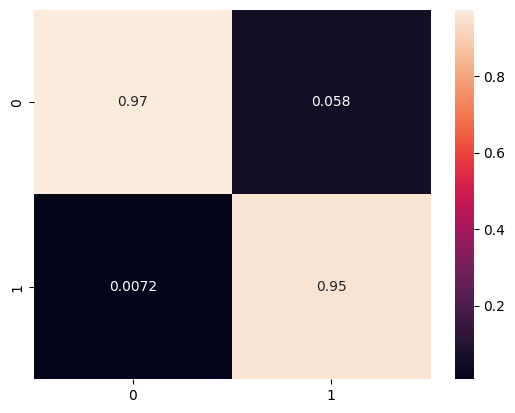

In [4]:
dist = lambda a, b: sum((ae - be) ** 2 for ae, be in zip(a, b)) ** 0.5
argsort = lambda seq: sorted(range(len(seq)), key=seq.__getitem__)

def predict(X_train, x, y_train, k):
    distances = [dist(x, xt) for xt in X_train]
    nearest = argsort(distances)
    return 1 if sum(y_train[i] for i in nearest[:k]) / k > 0.5 else 0

diag = df["diagnosis"].map({"M": 1, "B": 0})
df_noresult = df.drop("diagnosis", axis=1)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df_noresult)
df_scaled = scaler.transform(df_noresult)

result = [[0, 0], [0, 0]]

def check(i, df, diag):
    df_without_i = np.vstack([df[:i], df[i + 1:]])
    diag_without_i = np.hstack([diag[:i], diag[i + 1:]])
    result[predict(df_without_i, df[i], diag_without_i, 6) == 1][diag[i]] += 1

for i in range(len(df)):
    check(i, df_scaled, diag)

print(f"Prediction completed with {result[0][0]} Hits, {result[0][1]} Misses, {result[1][0]} False alarms, and {result[1][1]} Correct rejections.")
print("Accuracy: ", (result[0][0] + result[1][1]) / sum(sum(result, [])))

def f1_score(result, i, j):
    tp = result[i][j]
    fp = result[i][(j + 1) % 2]
    fn = result[(i + 1) % 2][j]
    return 2 * tp / (2 * tp + fp + fn)


## K-Nearest Neighbors 알고리즘의 장단점

다른 모든 알고리즘과 같이, K-Nearest Neighbors 알고리즘도 장단점을 가지고 있습니다. 아래에 제시된 장단점을 잘 이해하고 적합한 문제에 적합한 알고리즘을 연결지을 수 있어야 합니다.

#### 장점
1. **단순함과 이해하기 쉬움**

    K-Nearest Neighbors 알고리즘은 이해하기 쉽고 구현하기 간단한 알고리즘입니다. 많은 복잡한 매개변수를 조정할 필요가 없어 초보자도 쉽게 사용할 수 있습니다​

2. **모델 훈련이 필요 없음**

    K-Nearest Neighbors 알고리즘은 'lazy learning' 알고리즘으로, 훈련 단계가 필요 없습니다. 이는 새로운 데이터 포인트가 있을 때마다 즉시 예측을 수행할 수 있다는 것을 의미합니다​.

3. **적응성**

    다양한 거리 측정 방법(예: 유클리드 거리, 맨하탄 거리 등)을 사용하여 여러 유형의 데이터에 적응할 수 있습니다. 이는 K-Nearest Neighbors 알고리즘이 여러 가지 데이터 유형에 대해 유연하게 적용될 수 있음을 의미합니다​​.

4. **다양한 응용 분야**

    K-Nearest Neighbors 알고리즘은 분류뿐만 아니라 회귀 문제에도 사용할 수 있습니다. 예를 들어, 이미지 인식, 추천 시스템, 이상 탐지 등 다양한 분야에서 활용될 수 있습니다​​.

#### 단점
1. **계산 비용**

    데이터셋이 클 경우, 예측 시 모든 데이터 포인트 간의 거리를 계산해야 하므로 계산 비용이 매우 높아질 수 있습니다. 이는 큰 데이터셋에서는 비효율적일 수 있습니다​.

2. **메모리 사용량**

    모든 훈련 데이터를 저장해야 하므로 메모리 사용량이 큽니다. 이는 특히 메모리가 제한된 환경에서는 문제가 될 수 있습니다​.

3. **고차원 데이터에서의 성능 저하**

    '차원의 저주' 문제로 인해, 고차원 데이터에서는 거리가 덜 의미 있게 되어 성능이 저하될 수 있습니다. 많은 특징을 가진 데이터셋에서는 성능이 떨어질 수 있습니다​.

4. **잡음에 민감**

    K-Nearest Neighbors 알고리즘은 데이터에 있는 잡음이나 이상치에 민감합니다. 이는 잘못된 분류를 유발할 수 있으며, 데이터 전처리 과정에서 잡음을 제거하는 것이 중요합니다​.

5. **특성 스케일링 필요**

    K-Nearest Neighbors 알고리즘은 거리 기반 알고리즘이므로, 각 특징의 스케일이 유사해야 합니다. 그렇지 않으면 일부 특징이 다른 특징보다 더 큰 영향을 미칠 수 있습니다. 따라서 데이터 전처리 단계에서 특성 스케일링이 필요합니다​.